# ViT OOD in PyTorch

In [ ]:
device = 'cuda:0'

## dataset

In [ ]:
from datasets import load_dataset

train_ds, test_ds = load_dataset('cifar10', split=['train', 'test[:2000]'])
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
cifar100_ds = load_dataset('cifar100', split='test[:2000]');

cifar10_train_ds = load_dataset('cifar10', split='train')

Found cached dataset cifar100 (/root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset cifar100 (/root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142)
Found cached dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


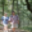

In [ ]:
cifar100_ds[1]['img']

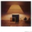

In [ ]:
train_ds[0]['img']

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

KeyError: 'label'

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [ ]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)

val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [ ]:
cifar100_ds.set_transform(val_transforms)
cifar10_train_ds.set_transform(val_transforms)

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [ ]:
from datasets import load_metric
# import evaluate
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def collate_fn_cifar100(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["fine_label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=4)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=4)
cifar100_dataloader = DataLoader(cifar100_ds, collate_fn=collate_fn_cifar100, batch_size=4)
cifar10_train_dataloader = DataLoader(cifar10_train_ds, collate_fn=collate_fn, batch_size=4)

In [ ]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [ ]:
trainer.train()

## Classification output

In [ ]:
outputs = trainer.predict(test_ds)

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

# Evaluate

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_logit(model, dl):
    l_pred = []
    for xx in tqdm(dl):
        with torch.no_grad():
            pred = model(xx['pixel_values'].cuda(), output_hidden_states=False)
            # pred.logits
            # pred.hidden_states
        l_pred.append(pred.logits.detach().cpu())
    return torch.cat(l_pred)

def get_prelogit(model, dl):
    l_pred = []
    for xx in tqdm(dl):
        with torch.no_grad():
            out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
            out = out.hidden_states[-1][:,0,:]
            out = model.vit.layernorm(out)
        l_pred.append(out.detach().cpu())
    return torch.cat(l_pred)

In [ ]:
cifar10_pred = get_logit(model, test_dataloader)
cifar100_pred = get_logit(model, cifar100_dataloader)

In [ ]:
cifar100_pred.shape, cifar10_pred.shape

In [ ]:
from torch.nn.functional import softmax

In [ ]:
cifar100_msp = torch.max(softmax(cifar100_pred, dim=1),dim=1).values
cifar10_msp = torch.max(softmax(cifar10_pred, dim=1),dim=1).values

In [ ]:
cifar100_msp.shape

In [ ]:
import sys
sys.path.append('../')
from utils import roc_btw_arr

In [ ]:
roc_btw_arr(cifar10_msp, cifar100_msp)

### Mahalanobis distance

In [ ]:
prelogit = get_prelogit(model, cifar10_train_dataloader)

In [ ]:
prelogit

In [ ]:
cifar10_train_label = torch.tensor([cifar10_train_ds[i]['label'] for i in range(len(cifar10_train_ds))])

In [ ]:
cifar10_train_label.shape

In [ ]:
'''mahalanobis statistics computation'''
l_mean = []
l_outer = []
for k in range(10):
    subset_x = prelogit[cifar10_train_label == k]
    subset_mean = torch.mean(subset_x, dim=0, keepdim=True)
    # subset_outer = torch.cov(subset_x - subset_mean, correction=0) * len(subset_x)
    v = subset_x - subset_mean
    subset_outer = v.T.mm(v)
    l_mean.append(subset_mean)
    l_outer.append(subset_outer)
pooled_cov = torch.sum(torch.stack(l_outer), dim=0) / len(prelogit)
all_means = torch.stack(l_mean, dim=-1)
invcov = torch.linalg.inv(pooled_cov)

In [ ]:
'''relative mahalanobis statistics'''
whole_mean = torch.mean(prelogit, dim=0, keepdim=True)
v = prelogit - whole_mean
whole_cov = v.T.mm(v) / len(prelogit)
whole_invcov = torch.linalg.inv(whole_cov)

In [ ]:
pooled_cov

In [ ]:
pooled_cov[0,:10]

In [ ]:
whole_cov[0,:10]

In [ ]:
def forward_maha(xx, mean, invcov):
    """
    mean: [1, D, K]
    invcov: [D, D]
    """
    z = xx.unsqueeze(-1) - mean
    op1 = torch.einsum('ijk,jl->ilk', z, invcov)
    op2 = torch.einsum('ijk,ijk->ik', op1, z)  # [B, K]
    
    return torch.min(op2, dim=1).values
    
def forward_maha_dl(model, dataloader, mean, invcov):
    l_score = []
    for xx in tqdm(dataloader):
        
        out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
        out = out.hidden_states[-1][:,0,:]
        out = model.vit.layernorm(out)
        
        prelogit = out.detach().cpu()
        score = forward_maha(prelogit, mean, invcov)
        l_score.append(score)
    return torch.cat(l_score)
# forward_maha(subset_x, all_means, invcov)

cifar10_maha = forward_maha_dl(model, test_dataloader, all_means, invcov)
cifar100_maha = forward_maha_dl(model, cifar100_dataloader, all_means, invcov)

In [ ]:
roc_btw_arr(cifar100_maha, cifar10_maha)

In [ ]:
def forward_rel_maha_dl(model, dataloader, mean, invcov, whole_mean, whole_invcov):
    l_score = []
    for xx in tqdm(dataloader):
        
        out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
        out = out.hidden_states[-1][:,0,:]
        out = model.vit.layernorm(out)
        
        prelogit = out.detach().cpu()
        maha = forward_maha(prelogit, mean, invcov)
        rel_maha = forward_maha(prelogit, whole_mean, whole_invcov)
        l_score.append(maha - rel_maha)
    return torch.cat(l_score)

In [ ]:
cifar10_rel_maha = forward_rel_maha_dl(model, test_dataloader, all_means, invcov, whole_mean.unsqueeze(-1), whole_invcov)
cifar100_rel_maha = forward_rel_maha_dl(model, cifar100_dataloader, all_means, invcov, whole_mean.unsqueeze(-1), whole_invcov)

In [ ]:
dataloader = cifar100_dataloader; mean = all_means
l_score = []
for xx in tqdm(dataloader):

    out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
    out = out.hidden_states[-1][:,0,:]
    out = model.vit.layernorm(out)

    prelogit = out.detach().cpu()
    maha = forward_maha(prelogit, mean, invcov)
    rel_maha = forward_maha(prelogit, whole_mean.unsqueeze(-1), whole_invcov)
    l_score.append(maha - rel_maha)
    break

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
dataloader = test_dataloader; mean = all_means
l_score = []
for xx in tqdm(dataloader):

    out = model(xx['pixel_values'].cuda(), output_hidden_states=True)
    out = out.hidden_states[-1][:,0,:]
    out = model.vit.layernorm(out)

    prelogit = out.detach().cpu()
    maha = forward_maha(prelogit, mean, invcov)
    rel_maha = forward_maha(prelogit, whole_mean.unsqueeze(-1), whole_invcov)
    l_score.append(maha - rel_maha)
    break

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
maha

tensor([ 513.5379,  419.4996,  958.2922, 1164.3411])

In [ ]:
rel_maha

tensor([ 506.6990,  423.5738,  963.2341, 1211.3817])

In [ ]:
a = next(iter(cifar100_dataloader))['pixel_values']

In [ ]:
a.shape

torch.Size([4, 3, 224, 224])

In [ ]:
x = prelogit[:4]

In [ ]:
forward_maha(x, whole_mean.unsqueeze(-1), whole_invcov)

tensor([ 408.0565, 1345.5720, 1123.5537,  992.5492])

In [ ]:
forward_maha(x, all_means, invcov)

tensor([ 381.7560, 1362.5967, 1141.3389,  988.6481])

In [ ]:
invcov[0][0:4]

tensor([16501669., 16561424., 17615810., 17188552.])

In [ ]:
whole_invcov[0][0:4]

tensor([-190196.2812, -191974.5312, -204199.4375, -199183.9219])

In [ ]:
all_means[0][:5].sum()

tensor(-0.3713)

In [ ]:
whole_mean[0][:5].sum()

tensor(-0.0371)

In [ ]:
roc_btw_arr(cifar100_rel_maha, cifar10_rel_maha)

In [ ]:
import matplotlib.pyplot as plt

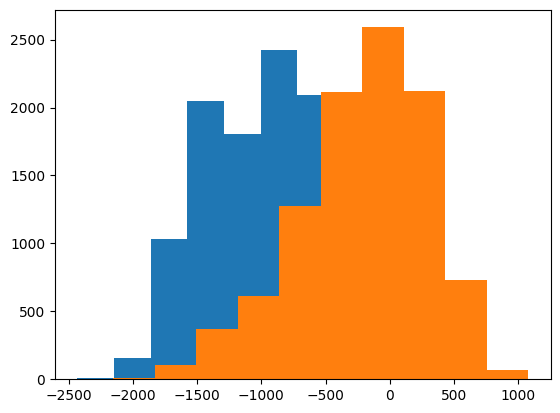

In [ ]:
plt.hist(cifar10_rel_maha.numpy());
plt.hist(cifar100_rel_maha.numpy());

In [ ]:
roc_btw_arr(cifar100_rel_maha, cifar10_rel_maha)

0.49329033